In [ ]:
from collections import OrderedDict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.feature_extraction.text import TfidfVectorizer

from utils.preprocessor import Stopwords_preprocessor
from utils.logging import beir_metrics_to_markdown_table
from IPython.display import Markdown

# from rank_bm25 import BM25Okapi as BM25
from transformers import logging, AutoTokenizer
from beir.datasets.data_loader import GenericDataLoader
from beir.retrieval.evaluation import EvaluateRetrieval

import pathlib
import torch
from torch import nn

C:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [3]:
# from beir import util
# dataset =  'trec-covid' # "nfcorpus" 
# url = "https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{}.zip".format(dataset)
# data_path = util.download_and_unzip(url, 'data')

In [4]:
corpus_name = 'scifact'
corpus_name = 'trec-covid'
# corpus_name = 'nfcorpus'

corpus, queries, qrels = GenericDataLoader(f'data/{corpus_name}').load(split="test")
corpus_text = [v['text'] for k,v in corpus.items()]

100%|██████████████████████████████████████████████████████████████████████| 171332/171332 [00:01<00:00, 125472.06it/s]


In [5]:
def tokenize(x):
    return tokenizer.convert_ids_to_tokens(tokenizer.encode(x, add_special_tokens=False))

vectorizer = TfidfVectorizer(tokenizer=tokenize, vocabulary=tokenizer.vocab)
%time vectorizer.fit(corpus_text)

C:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
C:\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:1368: UserWarning: Upper case characters found in vocabulary while 'lowercase' is True. These entries will not be matched with any documents
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (583 > 512). Running this sequence through the model will result in indexing errors


CPU times: total: 2min 21s
Wall time: 2min 24s


TfidfVectorizer(tokenizer=<function tokenize at 0x000001CC92951300>,
                vocabulary={'!': 999, '"': 1000, '#': 1001, '##!': 29612,
                            '##"': 29613, '###': 29614, '##$': 29615,
                            '##%': 29616, '##&': 29617, "##'": 29618,
                            '##(': 29619, '##)': 29620, '##*': 29621,
                            '##+': 29622, '##,': 29623, '##-': 29624,
                            '##.': 29625, '##/': 29626, '##0': 2692,
                            '##00': 8889, '##01': 24096, '##0s': 16223,
                            '##1': 2487, '##10': 10790, '##100': 18613,
                            '##11': 14526, '##12': 12521, '##13': 17134,
                            '##14': 16932, '##15': 16068, ...})

In [6]:
subpath = '20240704.20:55:54' # 4 abs_bert, bookcorpus
subpath = '20240704.21:19:36' # 5 abs_bert, wiki
# subpath = '20240704.21:26:11' # 6 abs_bert, bookcorpus, xavier_init_embedding
subpath = '20240704.21:33:23' # 7 abs_bert, wiki, xavier_init_embedding
# subpath = '20240709.10:26:55' # abs_architecture, lr 1e-5~1e-3, early exploded
subpath = '20240709.11:13:35' # abs_architecture, lr 1e-5~1e-3, exploded at 10000
subpath = '20240709.12:14:48' # time_attention, lr 1e-5~1e-3, exploded at before 6000

subpath = '20240710.23:13:03' # all1_as_pivot, mask_prob0.15
subpath = '20240711.03:00:33' # all1_layerNorm
subpath = '20240711.03:33:04' # all1_layerNorm, lr 2e-5
subpath = '20240711.03:33:24' # all1_layerNorm, lr 5e-6
# subpath = '20240711.03:48:45' # all1_layerNorm, lr 1e-6
subpath = '20240711.15:40:27' # bookcorpus, lr 4e-5
# subpath = '20240711.16:14:06' # multi granularity, bookcorpus, lr 4e-5 (寫錯, granularity 都很小)
# subpath = '20240711.17:01:29' # log_granularity [1,2,3,5,6,7,8,9], bookcorpus, lr 4e-5
# subpath = '20240711.17:23:01' # log_granularity [1,2,2,3,5,5,6,6], bookcorpus, lr 4e-5
subpath = '20240729-16-38-43'  # abs_bert, 768dim

weight norms, min: 0.36487871408462524, max: 1.0825238227844238
min norms: ['[PAD]', '[MASK]', 'house', 'man', 'he', 'body', 'girl', 'mother', 'she', 'jack']
max norms: ['ヒ', '##中', '##リ', '##昭', '##ɲ', '##;', '氷', '##ŋ', '[unused322]', '##国']
bias norms, min: -5.834859371185303, max: 0.18217182159423828
min norms: ['[PAD]', '[MASK]', '##ckey', '##dust', 'ancestry', 'conjunction', 'harmonic', 'locating', 'jing', '##hore']
max norms: ['-', 'back', 'to', 'in', 'that', '##s', 'was', 'the', 'and', ',']


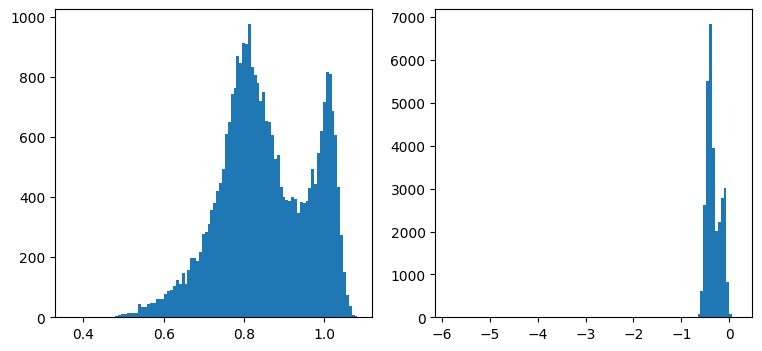

In [7]:
epoch_num = 0
batch_num = 325000

folder_path = pathlib.Path('data/abs_bert/')
# model = torch.load(folder_path/subpath/f'batch_{batch_num}-model.pt', map_location='cpu')
model = torch.load(folder_path/subpath/f'epoch_{epoch_num}-batch_{batch_num}-model.pt', map_location='cpu', weights_only=False)

word_reprs = model.word_embeddings().detach()

vectors = word_reprs

_, (ax_w, ax_b) = plt.subplots(1, 2, figsize=[9, 4])

# weight stats
norms = np.linalg.norm(vectors, axis=1)
indices = norms.argsort()
print(f"weight norms, min: {norms.min()}, max: {norms.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
_ = ax_w.hist(norms, bins=100)

# bias stats
biases = model.bias.detach()
indices = biases.argsort()
print(f"bias norms, min: {biases.min()}, max: {biases.max()}")
print("min norms:", tokenizer.convert_ids_to_tokens(indices[:10]))
print("max norms:", tokenizer.convert_ids_to_tokens(indices[-10:]))
if hasattr(model, 'predictor') and hasattr(model.predictor, 'base_vec'):
  print(f"base vec norm: {model.predictor.base_vec.norm()}")
_ = ax_b.hist(biases, bins=100)

In [8]:
def mean_vector(text, word_reprs=word_reprs):
  ids = tokenizer.encode(text, add_special_tokens=False)
  if len(ids) == 0:
      return np.zeros(word_reprs.shape[1])
  return word_reprs[ids].mean(axis=0)

def sum_vector(text):
  ids = tokenizer.encode(text, add_special_tokens=False)
  return word_reprs[ids].sum(axis=0)

def model_mean(text):
    return model(**tokenizer(text, return_tensors='pt'))[0][0].mean(axis=0)

def idf_mean_vector(text, word_reprs=word_reprs):
  ids = tokenizer.encode(text, add_special_tokens=False)
  # return (vectorizer.idf_[ids] @ word_reprs[ids]) / (len(ids) + 1e-8) # 這個比較慢，可能跟 contiguous 有關
  return np.einsum('ld,l', word_reprs[ids], vectorizer.idf_[ids]) / (len(ids) + 1e-8)

from sklearn.metrics.pairwise import cosine_similarity
mask_id = tokenizer.convert_tokens_to_ids('[MASK]')
score = cosine_similarity(word_reprs, word_reprs[[mask_id]])
score = 1 - np.maximum(score, 0)
scored_word_reprs = torch.from_numpy(score) * word_reprs

# def cos_scored_mean_vector(text):
#   ids = tokenizer.encode(text, add_special_tokens=False)
  # return scored_word_reprs[ids].sum(axis=0)

cos_weighted_mean_vector = lambda text: mean_vector(text, scored_word_reprs)
cos_weighted_idf_mean_vector = lambda text: idf_mean_vector(text, scored_word_reprs)

max_norm = word_reprs[norms.argmax()]
score = cosine_similarity(word_reprs, [max_norm])
bipolar_reprs = torch.from_numpy(1 - np.abs(score)) * word_reprs

bipolar_weighted_mean_vector = lambda text: mean_vector(text, bipolar_reprs)
bipolar_weighted_if_mean_vector = lambda text: idf_mean_vector(text, bipolar_reprs)

In [9]:
# inputs = tokenizer('I love you.', return_tensors='pt', add_special_tokens=False)
# histories = [his.expand(4, *[-1]*(len(his.shape)-1)) for his in model.initial_states()['histories']]
# output, next_histories = model.forward(inputs['input_ids'][0], 1, histories)

In [10]:
model(**tokenizer('a an apple', return_tensors='pt'))[0].shape

torch.Size([1, 5, 768])

In [ ]:
method = idf_mean_vector
method = mean_vector
method = model_mean
# method = sum_vector
# method = cos_weighted_mean_vector
# method = cos_weighted_idf_mean_vector
# method = bipolar_weighted_mean_vector
# method = bipolar_weighted_if_mean_vector

part = 'text'
# part = 'title'

%time text_vec_dict = OrderedDict({k: method(v[part]) for k, v in corpus.items()})
%time query_vec_dict = OrderedDict({k: method(v) for k, v in queries.items()})
text_vecs = np.stack(list(text_vec_dict.values()))

In [ ]:
metric = 'euclidean'
metric = 'cosine'

def score(query_vector, metric=metric):
    return (1/pairwise_distances(query_vector[None, :], text_vecs, metric=metric))[0]

%time results = {qid: dict(zip(text_vec_dict.keys(), score(query_vector).tolist())) \
            for qid, query_vector in query_vec_dict.items()}

metrics = EvaluateRetrieval.evaluate(qrels, results, [1, 3, 5, 10, 100, 1000])

flatten_metrics = {k: v for metric_type in metrics for k, v in metric_type.items()}
metric_names, metric_values = zip(*flatten_metrics.items())
print(*metric_names, sep='\t')
print(*metric_values, sep='\t')
print()

md = beir_metrics_to_markdown_table(*metrics)
Markdown(md)

In [23]:
# # write first 10 questions and top 10 answer to file

# samples = list(results.items())[:10]
# for q_num, score_dict in samples:
#     with open(f'question_{q_num}.txt', 'w') as f:
#         f.write(f'{queries[q_num]}\n\n')
#         tokens = tokenizer.convert_ids_to_tokens(tokenizer(queries[q_num], add_special_tokens=False)['input_ids'])
#         f.write(f'{tokens}\n\n')
        
#         text_ids, text_scores = zip(*score_dict.items())
#         text_scores = np.array(text_scores)
#         top_10_idx = np.argsort(text_scores)[:-10:-1]

#         for idx in top_10_idx:
#             f.write(f'{corpus[text_ids[idx]]}\n\n')

In [18]:
# #test: 看每個字往時間方向逆向轉一個 t 後，附近的字為何。理論來說會是跟這個字無關的字 (text independent)，因為這個旋轉抵銷了時間旋轉

# inverse_metric_theta = - 1/model.predictor.rotary_denom**(model.predictor.dimension_nums/model.predictor.dim)
# inverse_pos_rotation = torch.complex(inverse_metric_theta.cos(), inverse_metric_theta.sin())
# least_effective_position_of_the_word = model.predictor.all_word_embeddings() * inverse_pos_rotation
# least_effective_position_of_the_word = torch.concat([least_effective_position_of_the_word.real, least_effective_position_of_the_word.imag], dim=-1).detach().numpy()

# least_effective_position_of_the_word.shape

# %time d = pairwise_distances(word_reprs, least_effective_position_of_the_word, metric='euclidean') # metric='cosine'

# %time pair = d.argsort(axis=1)[:, :10]

# for input_id in tokenizer.encode(text_sample):
#     print(f'{tokenizer.convert_ids_to_tokens(input_id)}: {tokenizer.convert_ids_to_tokens(pair[input_id])}')